# Logistic Regression for Telco Churn Analysis

#### Utilizing data retrieved from a Kaggle dataset to build a logistic regression model aimed at predicting customer churn rates. Also included is a statistical analysis to identify the most signifcant feautres and their correlation to churn rates

In [ ]:
import requests
import pandas as pd
import numpy as np
import kagglehub
import os
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from scipy import stats
;

''

## Data Acquisition

In [34]:
path = kagglehub.dataset_download("blastchar/telco-customer-churn",path='WA_Fn-UseC_-Telco-Customer-Churn.csv')

100%|██████████| 955k/955k [00:00<00:00, 1.83MB/s]


In [35]:
destination = os.environ.get('LR_Destination')

alr_exists = str(destination + '/' + 'WA_Fn-UseC_-Telco-Customer-Churn.csv')

if os.path.exists(alr_exists):
        os.remove(alr_exists)
        print(f"File deleted sucessfully.")
else:
        print(f"File not found.")

File deleted sucessfully.


In [36]:
source = os.environ.get('LR_SOURCE')

allfiles = os.listdir(source)

for f in allfiles:
        src_path = os.path.join(source, f)
        dst_path = os.path.join(destination, f)
        os.rename(src_path, dst_path)

In [37]:
str(destination + '/' + 'WA_Fn-UseC_-Telco-Customer-Churn.csv')  
ChurnData = pd.read_csv(str(destination + '/' + 'WA_Fn-UseC_-Telco-Customer-Churn.csv'))

## Data Proccessing

In [38]:
#Pre-Processing of Data, removing CustomerID, and Converting TotalCharges into a float.
ChurnData.drop('customerID',axis=1,inplace=True)
ChurnData['TotalCharges'] = pd.to_numeric(ChurnData['TotalCharges'], errors='coerce').fillna(pd.to_numeric(ChurnData['TotalCharges'], errors='coerce').mean())

In [39]:
# most likely the columns that are categorical -> not numerical (Creating function to dynamically assign integer values to categorical information)
# Some data is multicollinear, meaning that there is redundant information.
for column in ChurnData:
    if(ChurnData[column].dtype == 'object' and len(ChurnData[column].unique()) > 2):
            ChurnData = pd.get_dummies(ChurnData, columns=[str(column)], drop_first=True)

#Convert booleans created from pd.get_dummies and map them dynamically into 0s and 1s
for column in ChurnData:
      if(ChurnData[column].dtypes == bool):
            ChurnData[column] = ChurnData[column].astype(int)

In [40]:
#Retrieving columns that were generated by pandas dummy variables and calculating VIF for detecting colinearity
data = ChurnData.loc[:, ChurnData.columns.str.contains("_")]

vif_df = pd.DataFrame()
vif_df["feature"] = data.columns
vif_df["VIF_Score"] = [variance_inflation_factor(data.values, i) for i in range(len(data.columns))]

#Retrieving scores that were greater than 10, indicates need to be dropped from original dataset
vif_df = vif_df[vif_df["VIF_Score"] > 10]['feature']

In [41]:
cols = [col for col in ChurnData.columns if col not in vif_df.to_numpy()]
ChurnData = ChurnData.loc[:, cols]

In [42]:
#Mapping remaining yes/no columns to 0s and 1s dynamically
yes_no_map = {'Yes' : 1, 'No' : 0}

map_yes_no_columns = []
for cols in ChurnData:
    if 'Yes' in ChurnData[cols].unique() or 'No' in ChurnData[cols].unique():
        map_yes_no_columns.append(ChurnData[cols].name)

for row in ChurnData[map_yes_no_columns]:
    ChurnData[row] = ChurnData[map_yes_no_columns][row].map(yes_no_map)

ChurnData.rename(columns={'gender' : 'Male'}, inplace=True)

In [43]:
gender_map = {'Male': 1, 'Female': 0}

ChurnData['Male'] = ChurnData["Male"].map(gender_map)

Optimization terminated successfully.
         Current function value: 0.578562
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.568022
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.567145
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564132
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.510569
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.578527
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.559405
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.559294
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.556590
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.578527
  

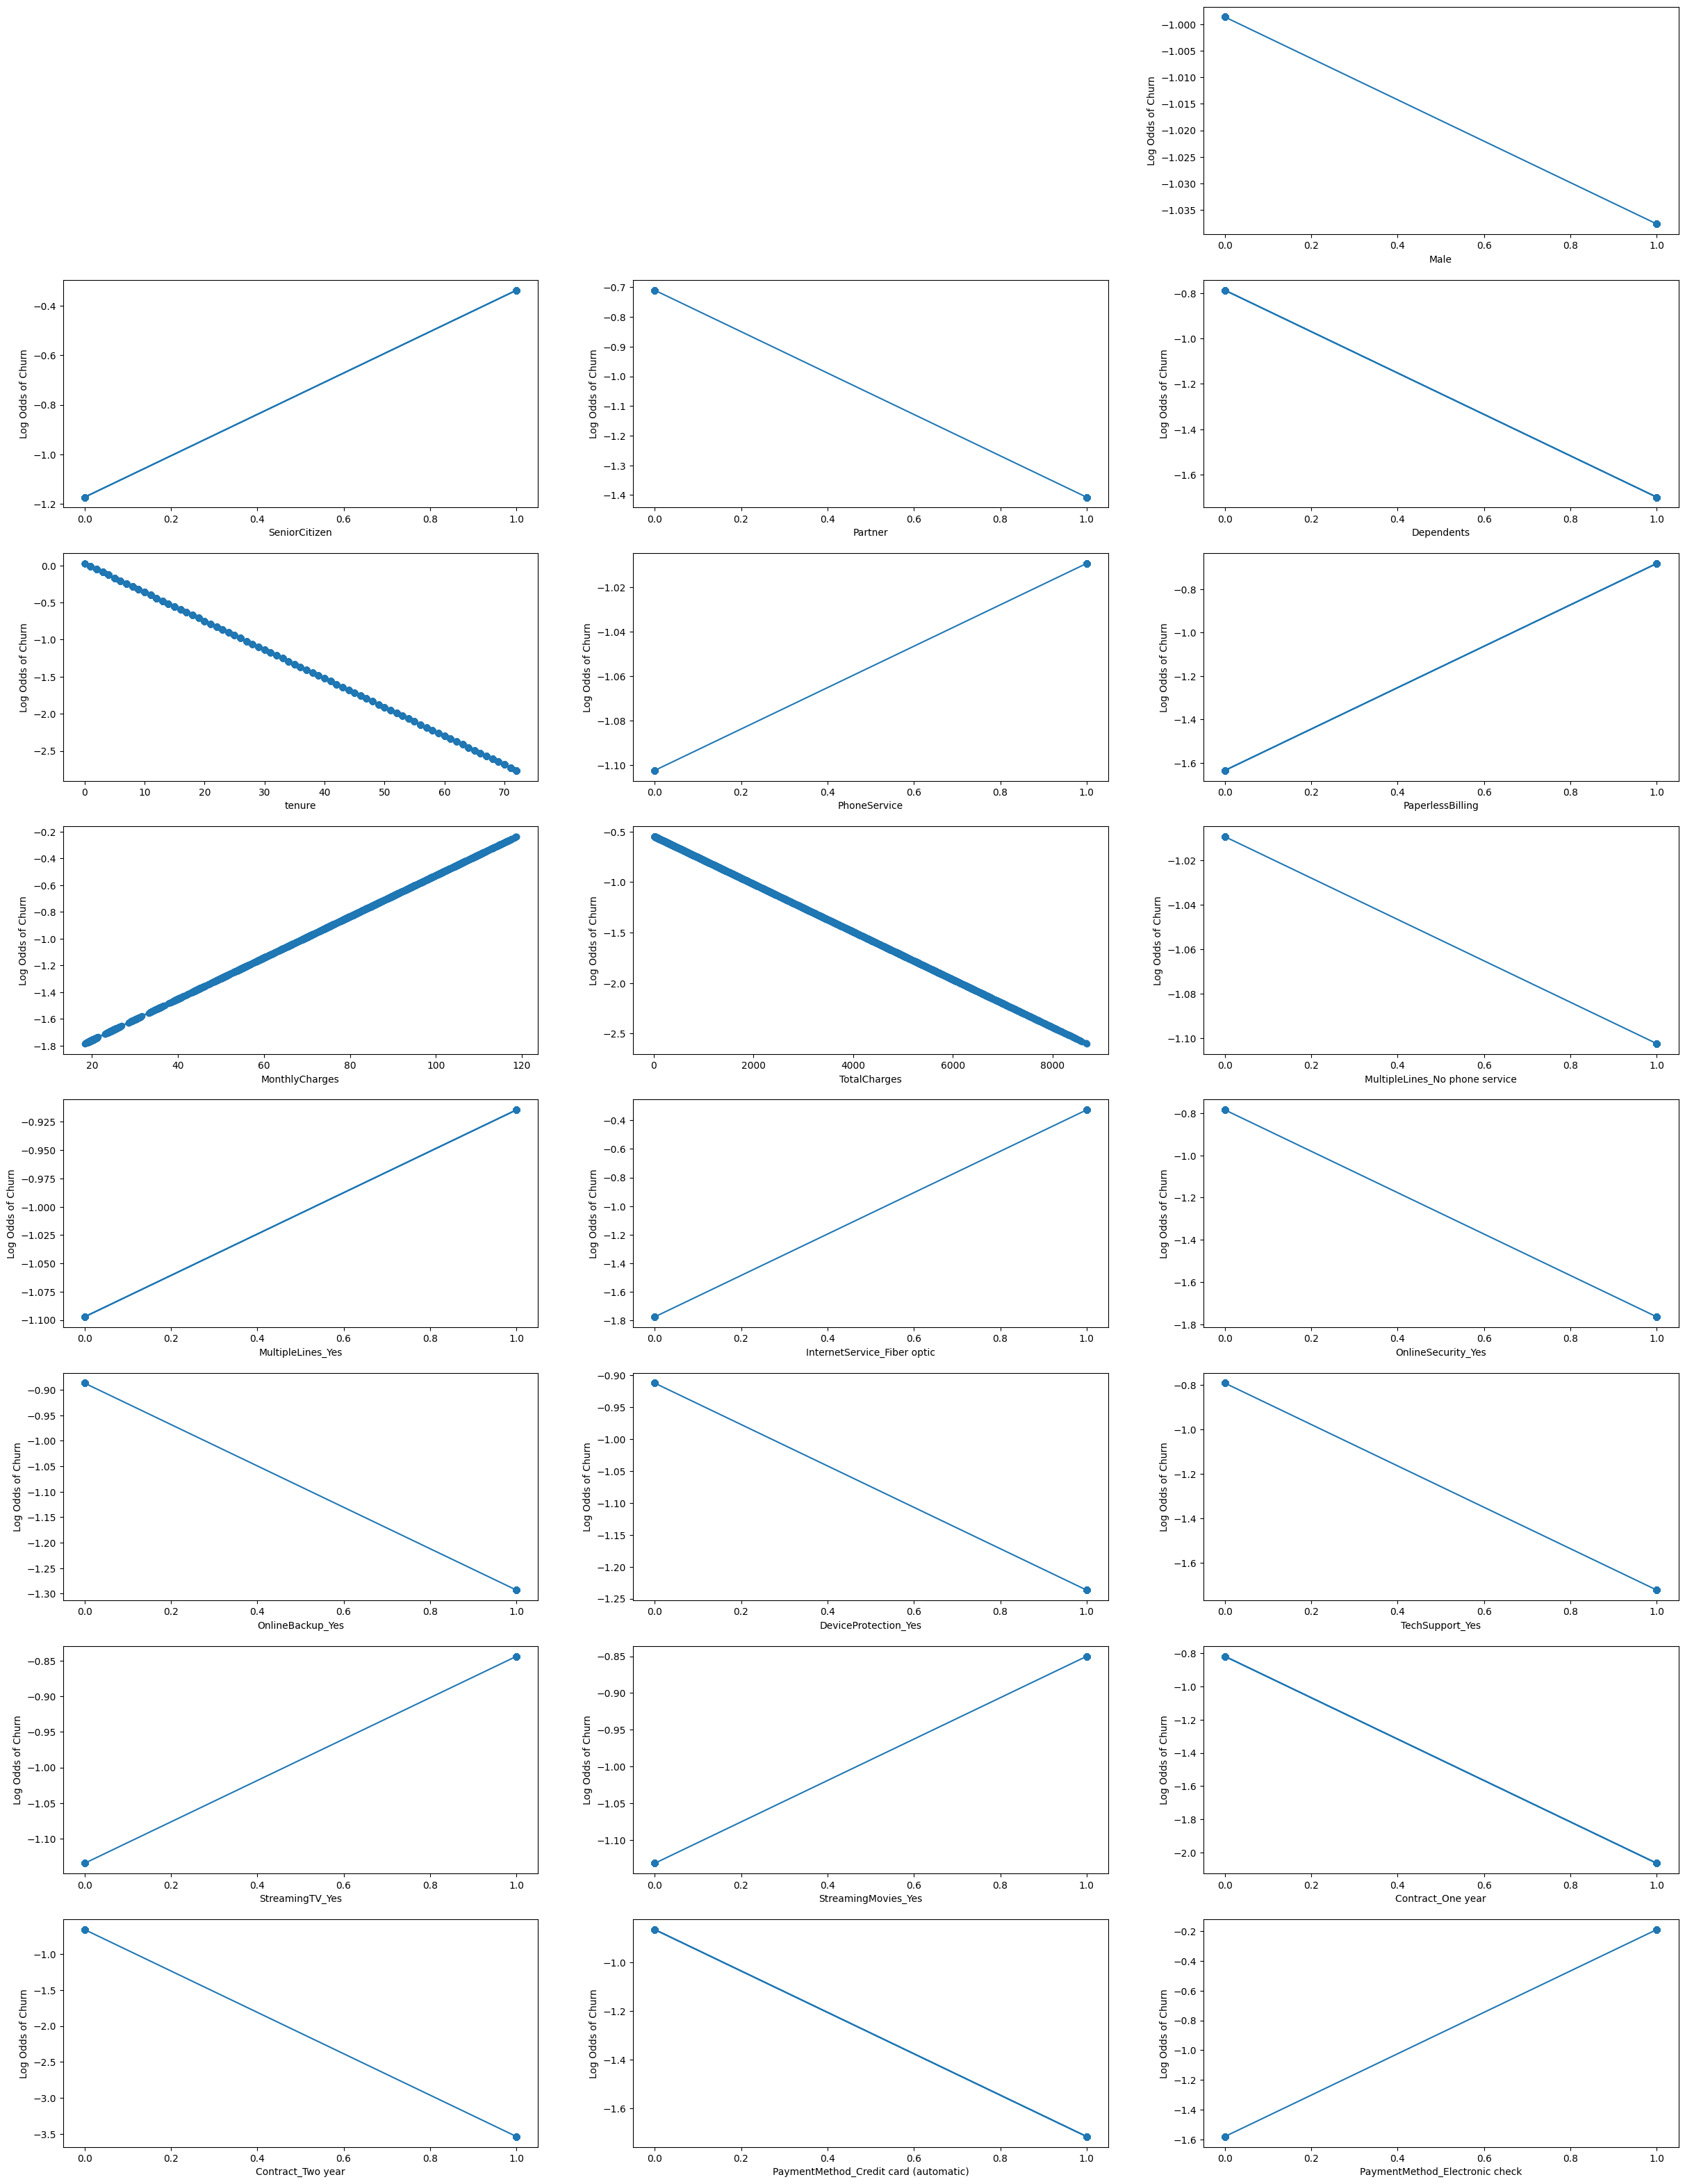

In [337]:
#Graphically showing linear relationships between independent and dependent variables (Major assumption of Logistic Regression)

figure, axis = plt.subplots(8, 3, figsize=(30, 40))

var_list = [item for item in ChurnData.columns if item != 'pred_prob' and item != 'log_odds' and item != 'Churn']

iterator = -2
for i in range(8):
    for j in range(3):
        if iterator >= 0:
            ind = sm.add_constant(ChurnData[var_list[iterator]])
            dep = ChurnData['Churn']

            two_d_model = sm.Logit(endog=dep,exog=ind).fit()

            pred_probs = two_d_model.predict(ind)

            log_odds = np.log((pred_probs) / (1 - pred_probs))
            slope, intercept, rvalue, pvalue, sterr = stats.linregress(ChurnData[var_list[iterator]], log_odds)

            axis[i,j].scatter(ChurnData[var_list[iterator]], log_odds)
            axis[i,j].plot(ChurnData[var_list[iterator]], slope*ChurnData[var_list[iterator]] + intercept)
            axis[i,j].set_xlabel(var_list[iterator])
            axis[i,j].set_ylabel('Log Odds of Churn')
            iterator += 1
        else:
            iterator += 1

figure.delaxes(axis[0,0])
figure.delaxes(axis[0,1])

## Logistic Regression Model Building

In [27]:
ChurnData_X, ChurnData_y = ChurnData.loc[:,ChurnData.columns != 'Churn'], ChurnData['Churn']

CD_X_train, CD_X_test, CD_y_train, CD_y_test = train_test_split(
    ChurnData_X, ChurnData_y, test_size=0.2, random_state=42
)

scaler = MinMaxScaler()

CD_X_train = scaler.fit_transform(CD_X_train)
CD_X_test = scaler.fit_transform(CD_X_test)

ChurnModel = LogisticRegression()
ChurnModel.fit(CD_X_train, CD_y_train);

## Metrics

In [28]:
churn_pred = ChurnModel.predict(CD_X_test)
accuracy = accuracy_score(CD_y_test, churn_pred)

print("Accuracy: {:.2f}%".format(accuracy * 100))

Accuracy: 82.33%


In [29]:
# Classification Report - Metrics related to the Logistic Regression
# Precision: How often model correctly predicts a positive outcome 
# Recall: How well model finds all positive instances in dataset
# F1-Score: combines precision and recall into a single score.

print("Confusion matrix: \n", confusion_matrix(CD_y_test, churn_pred))
print("\nClassification report: \n", classification_report(CD_y_test, churn_pred))

Confusion matrix: 
 [[939  97]
 [152 221]]

Classification report: 
               precision    recall  f1-score   support

           0       0.86      0.91      0.88      1036
           1       0.69      0.59      0.64       373

    accuracy                           0.82      1409
   macro avg       0.78      0.75      0.76      1409
weighted avg       0.82      0.82      0.82      1409



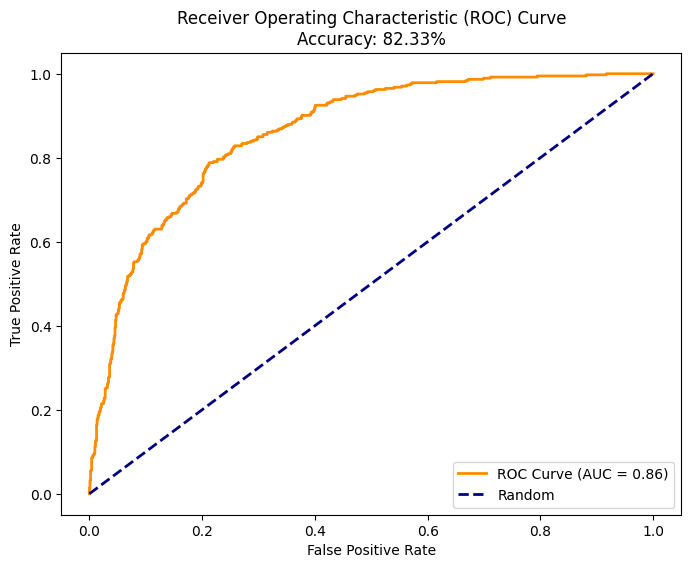

In [30]:
#AUC-ROC curve plots True Positive Rate against False Positive Rate at different thresholds showing how well a model can distinguish between customers that stay vs leave.
#TPR = p(True Positives are found)
#FPR = p(False Positives are found)


y_prob = ChurnModel.predict_proba(CD_X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(CD_y_test, y_prob)
roc_auc = auc(fpr, tpr)
 
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve\nAccuracy: {:.2f}%'.format(
    accuracy * 100))
plt.legend(loc="lower right")
plt.show()

## Statistical Analysis

In [31]:
#statsmodels.api has a package [logit] that provides a summary on the independent and dependent variables

sm.Logit(ChurnData_y, ChurnData_X)
mcs = sm.Logit(ChurnData_y, ChurnData_X).fit().summary()

relevant_metrics = pd.DataFrame()
model_coefficients = pd.DataFrame()

for i in range(2):
    if i == 0:
        relevant_metrics = pd.read_html(mcs.tables[0].as_html())
    else:
        model_coefficients = pd.read_html(mcs.tables[1].as_html())

mc_map = {0: 'ColumnName', 1: 'Coef', 2: 'Std. Err', 3: 'z', 4: 'P>|z|', 5: '[0.025', 6: '0.975]'}

model_coefficients[0].rename(mc_map,axis=1,inplace=True)
model_coefficients = model_coefficients[0].loc[1:];

relevant_metrics = relevant_metrics[0];

Optimization terminated successfully.
         Current function value: 0.414247
         Iterations 8


In [32]:
rename_nothing = {0: '', 1: ''}

other_info = relevant_metrics.iloc[:,[0,1]].rename(columns = rename_nothing)
other_info

,,
0,Dep. Variable:,Churn
1,Model:,Logit
2,Method:,MLE
3,Date:,"Sat, 22 Feb 2025"
4,Time:,09:18:44
5,converged:,True
6,Covariance Type:,nonrobust


In [33]:
# Statistically Significant Figures p < .05 indicates that we would obtaining the observed data assuming no relationship is les than 5%, meaning that the observed effect isn't random, but infers statistical significant relationship
# between feature and dependent variable [Churn]

# Paperless Billing -> Significant chance of Churn if customer has paperless billing, or by electronic check
# Senior Citizen -> Older people are more likely to leave Telco

model_coefficients.loc[model_coefficients['P>|z|'].astype(float) < .05].sort_values(by='Coef',ascending=False)

,ColumnName,Coef,Std. Err,z,P>|z|,[0.025,0.975]
7,PaperlessBilling,0.3479,0.074,4.677,0.000,0.202,0.494
22,PaymentMethod_Electronic check,0.3078,0.094,3.258,0.001,0.123,0.493
2,SeniorCitizen,0.2132,0.085,2.522,0.012,0.047,0.379
8,MonthlyCharges,0.0291,0.005,5.383,0.000,0.018,0.040
9,TotalCharges,0.0003,6.86e-05,4.370,0.000,0.000,0.000
6,PhoneService,-1.8277,0.231,-7.898,0.000,-2.281,-1.374
20,Contract_Two year,-1.4024,0.176,-7.979,0.000,-1.747,-1.058
19,Contract_One year,-0.6755,0.107,-6.293,0.000,-0.886,-0.465
10,MultipleLines_No phone service,-0.6094,0.209,-2.920,0.004,-1.018,-0.200
13,OnlineSecurity_Yes,-0.5431,0.094,-5.801,0.000,-0.727,-0.360
